In [1]:
!pip install opencv-python-headless==4.9.0.80

# Imports

In [2]:
import os
import cv2
import struct
import numpy as np
import matplotlib.pyplot as plt

# Constant

In [3]:
POSITIVE_SAMPLE_VIDEO = '/kaggle/input/coffee-packets/sample_video.mov'
NEGATIVE_SAMPLE_VIDEO = '/kaggle/input/coffee-packets/negative_sample.mov'

# Utils

In [4]:
def extract_video_frames(video_path):
    # Initialize a list to store the frames
    frames = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        # Loop through the video frames
        while True:
            # Read a frame from the video
            ret, frame = cap.read()

            # If the frame was read successfully, ret will be True
            if not ret:
                break

            # Convert the frame to a NumPy array and append it to the frames list
            frames.append(np.array(frame))

        # Release the video capture object
        cap.release()

    # Convert the list of frames to a NumPy array
    frames_array = np.array(frames)
    
    return frames_array


def write_vec_file(images, output_file):
    num_samples = len(images)
    img_height, img_width = images[0].shape[:2]
    
    with open(output_file, 'wb') as f:
        # Write header
        f.write(struct.pack('i', num_samples))
        f.write(struct.pack('i', img_width))
        f.write(struct.pack('i', img_height))
        f.write(struct.pack('i', 1))  # channels, assumed to be 1
        
        for img in images:
            # Flatten the image
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            f.write(struct.pack('i', 0))  # dummy value for the header of each image
            f.write(gray_img.tobytes())


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'bgr' (BRG)
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    if cmap == 'bgr':
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        cmap = None

    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()
    
    
def resize_images(img, width=120, height=260):
    resized_img = cv2.resize(img, (width, height))
    return resized_img

# Step1: Extract Video Frames

In [5]:
positive_sample_frames = extract_video_frames(POSITIVE_SAMPLE_VIDEO)
negative_sample_frames = extract_video_frames(NEGATIVE_SAMPLE_VIDEO)

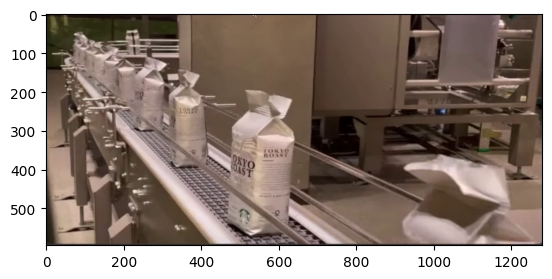

In [ ]:
plt_img(positive_sample_frames[26], cmap='bgr')

# Step2: Extract ROI (Region of intereset i.e Coffee Packs)

In [ ]:
coffee_packs = []

for frame in positive_sample_frames:
    # Define first ROI (Region of interest)
    x_start, y_start = 460, 190
    x_end, y_end = 640, 600
    roi = frame[y_start:y_end, x_start:x_end]
    coffee_packs.append(resize_images(roi))
    
    # Define second ROI (Region of interest)
    x_start, y_start = 300, 130 
    x_end, y_end = 420, 400
    roi = frame[y_start:y_end, x_start:x_end]
    coffee_packs.append(resize_images(roi))

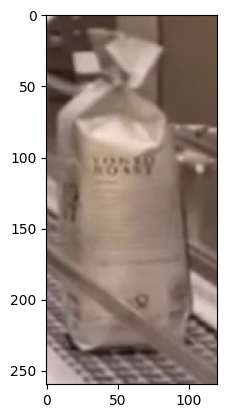

(260, 120, 3)


In [8]:
plt_img(coffee_packs[3], cmap='bgr')
print(coffee_packs[3].shape)

In [9]:
negative_samples = []

for frame in negative_sample_frames:
    # Define first ROI (Region of interest)
    x_start, y_start = 560, 190
    x_end, y_end = 740, 600
    roi = frame[y_start:y_end, x_start:x_end]
    negative_samples.append(resize_images(roi))

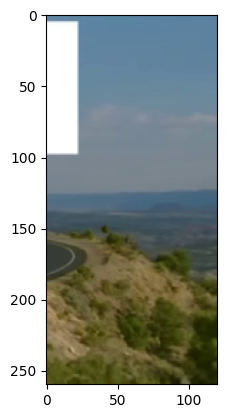

(260, 120, 3)


In [10]:
plt_img(negative_samples[100], cmap='bgr')
print(negative_samples[100].shape)

# Step3: Create Positive Samples

In [11]:
# Directory to save the images
output_dir = 'coffee_packs_dataset'
os.makedirs(output_dir, exist_ok=True)

# Save the images and create the positive samples file
with open('positive_samples.txt', 'w') as f:
    for i, img in enumerate(coffee_packs):
        img_path = os.path.join(output_dir, f'coffee_pack_{i}.jpg')
        cv2.imwrite(img_path, img)
        # Assuming the coffee pack occupies the entire image
        f.write(f'{img_path} 1 0 0 260 120\n')
        
# Write .vec file
write_vec_file(coffee_packs, 'positive_samples.vec')

In [12]:
# Directory to save the images
output_dir = 'negative_sample_dataset'
os.makedirs(output_dir, exist_ok=True)

# Save the images and create the positive samples file
with open('negative_samples.txt', 'w') as f:
    for i, img in enumerate(negative_samples):
        img_path = os.path.join(output_dir, f'negative_sample{i}.jpg')
        cv2.imwrite(img_path, img)
        # Assuming the coffee pack occupies the entire image
        f.write(f'{img_path} 1 0 0 260 120\n')
        
# Write .vec file
write_vec_file(negative_samples, 'negative_samples.vec')

# Step4: Train the Haar Cascade Classifier